In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [2]:
df = pd.read_csv('pharmodel_v5.csv')

In [3]:
df.shape

(1445, 173)

In [4]:
#df['safe_count'].mean()

In [5]:
df['y_class'] = df['vp_cat3']

In [6]:
df['safe_count'] = df[['safe_rash', 'safe_fever', 'safe_liver',
       'safe_throat', 'safe_skin', 'safe_nausea', 'safe_vomiting',
       'safe_allergic', 'safe_drowsiness', 'safe_stomach', 'safe_heart',
       'safe_stroke', 'safe_heartburn', 'safe_lightheadedness',
       'safe_sweating']].sum(axis=1)

In [9]:
# Create sym_count by counting the occurrences of 1's across sym features
df['sym_count'] = df[['sym_throat', 'sym_stomach', 'sym_sneezing', 'sym_sinus', 
                      'sym_pain', 'sym_nose', 'sym_nausea', 'sym_nasal', 'sym_migranie', 
                      'sym_menstrual', 'sym_itchy', 'sym_heart', 'sym_headache', 'sym_flu',
                      'sym_fever', 'sym_eyes', 'sym_digestion', 'sym_cough', 'sym_cold', 'sym_chest',
                      'sym_arthritis', 'sym_allergy', 'sym_acid']].sum(axis=1)

In [10]:
X_features = ['sym_count','fsa_flg', 'eff_max_str', 'eff_fast_acting', 'eff_long_lasting',
       'eff_non_drowsy', 'eff_kid', 'ingre_zinc', 'ingre_simethicone', 'ingre_pulsatilla',
       'ingre_phosphorus', 'ingre_phenylephrine', 'ingre_perfoliatum',
       'ingre_peppermint', 'ingre_omeprazole', 'ingre_naproxen',
       'ingre_menthol', 'ingre_magnesium', 'ingre_loratadine', 'ingre_kali',
       'ingre_ipecacuanha', 'ingre_ibuprofen', 'ingre_hydrobromide',
       'ingre_guaifenesin', 'ingre_gelsemium', 'ingre_fexofenadine',
       'ingre_famotidine', 'ingre_eupatorium', 'ingre_eucalyptus',
       'ingre_esomeprazole', 'ingre_echinacea', 'ingre_doxylamine',
       'ingre_diphenhydramine', 'ingre_dextromethorphan',
       'ingre_chlorpheniramine', 'ingre_cetirizine', 'ingre_calcium',
       'ingre_bryonia', 'ingre_antihistamine', 'ingre_aluminum',
       'ingre_acetaminophen', 'brand_zyrtec', 'brand_zicam',
       'brand_zegerid_otc', 'brand_vicks', 'brand_tylenol', 'brand_tums',
       'brand_time_cap_labs_inc', 'brand_theraflu', 'brand_rolaids',
       'brand_rite_aid', 'brand_quality_choice', 'brand_prilosec',
       'brand_prelief', 'brand_pepto_bismol', 'brand_pepcid', 'brand_nexium',
       'brand_natures_way', 'brand_mylanta', 'brand_mucinex', 'brand_motrin',
       'brand_midol', 'brand_major', 'brand_hylands', 'brand_goodsense',
       'brand_gaviscon', 'brand_flonase', 'brand_excedrin',
       'brand_coricidin_hbp', 'brand_claritin', 'brand_chloraseptic',
       'brand_boiron', 'brand_benadryl', 'brand_amazon_basic_care',
       'brand_allegra', 'brand_alka_seltzer_plus', 'brand_alka_seltzer',
       'brand_aleve', 'brand_airborne', 'brand_advil', 'brand_a2z_store',
       'manu_gsk', 'manu_jj', 'manu_bayer', 'manu_rb', 'manu_perrigo',
       'manu_pg', 'manu_sanofi', 'manu_ama', 'manu_major', 'manu_rite',
       'manu_boiron', 'manu_pfizer', 'manu_hyland', 'manu_alka',
       'manu_allegiant', 'manu_prestige', 'manu_dwight', 'manu_emc', 'manu_nw',
       'manu_walmart', 'manu_kirkland', 'manu_ohm', 'manu_reddy',
       'manu_bionpharma', 'manu_time', 'count_q_00', 'count_q_10',
       'count_q_20', 'count_q_30', 'inch_q_00', 'inch_q_10', 'inch_q_20',
       'inch_q_30', 'weight_q_00', 'weight_q_10', 'weight_q_20', 'weight_q_30',
             'safe_count']

In [11]:
data = df[df.cat=='cold'][X_features+['y_class','vp', 'cat', 'asin', 'rating', 'reviews', 'price']]

In [12]:
data.y_class.value_counts()

0    226
1    225
Name: y_class, dtype: int64

In [13]:
data.safe_count.mean()

1.6141906873614191

In [14]:
data[data.safe_count<1].rating.mean(), data[data.safe_count<1].price.mean()

(4.569565217391306, 19.08083850931672)

In [15]:
data[data.safe_count>=1].rating.mean(), data[data.safe_count>=1].price.mean()

(4.682170542635661, 12.950697674418613)

In [16]:
##data.safe_count.mean()

In [17]:
## binary safe count
data['safe_warn'] = 0
data.loc[data.safe_count>=1, 'safe_warn'] = 1

In [18]:
data.groupby('safe_count')['vp'].agg(['count', 'mean'])

,count,mean
safe_count,,
0,322,0.329716
1,13,0.393139
2,24,0.391470
3,4,0.468047
4,2,0.487705
5,20,0.415628
6,3,0.452184
7,17,0.366599
8,18,0.436415


In [19]:
from scipy.stats import chi2_contingency

# Selecting relevant columns for each group
#group1 = data[data['safe_count'] >= 1]
#group2 = data[data['safe_count'] == 0]

# Ingredients to compare
ingredients_to_compare = ['ingre_zinc', 'ingre_simethicone', 'ingre_pulsatilla',
       'ingre_phosphorus', 'ingre_phenylephrine', 'ingre_perfoliatum',
       'ingre_peppermint', 'ingre_omeprazole', 'ingre_naproxen',
       'ingre_menthol', 'ingre_magnesium', 'ingre_loratadine', 'ingre_kali',
       'ingre_ipecacuanha', 'ingre_ibuprofen', 'ingre_hydrobromide',
       'ingre_guaifenesin', 'ingre_gelsemium', 'ingre_fexofenadine',
       'ingre_famotidine', 'ingre_eupatorium', 'ingre_eucalyptus',
       'ingre_esomeprazole', 'ingre_echinacea', 'ingre_doxylamine',
       'ingre_diphenhydramine', 'ingre_dextromethorphan',
       'ingre_chlorpheniramine', 'ingre_cetirizine', 'ingre_calcium',
       'ingre_bryonia', 'ingre_antihistamine', 'ingre_aluminum',
       'ingre_acetaminophen']

# Initialize a DataFrame to store the chi-square test results
results = pd.DataFrame(columns=['Ingredient', 'Chi-Square Statistic', 'P-value', 'Count'])

# Perform chi-square test for each ingredient
for ingredient in ingredients_to_compare:
    # Create a contingency table
    contingency_table = pd.crosstab(data['safe_warn'], data[ingredient])
    
    # Check if there is data in the contingency table
    if contingency_table.size > 0:
        # Perform the chi-square test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # Append the results to the DataFrame
        results = results.append({'Ingredient': ingredient,
                                  'Chi-Square Statistic': chi2,
                                  'P-value': p,
                                 'Count': sum(data[ingredient])}, ignore_index=True)

# Display the results
print(results[results['P-value']<0.05])

                Ingredient  Chi-Square Statistic       P-value Count
3         ingre_phosphorus              3.960452  4.658119e-02    17
4      ingre_phenylephrine             35.309955  2.811911e-09   106
5        ingre_perfoliatum              6.936184  8.446911e-03    12
13       ingre_ipecacuanha              4.410719  3.571378e-02    14
15      ingre_hydrobromide             17.633946  2.677660e-05    32
16       ingre_guaifenesin              5.991915  1.437159e-02    85
17         ingre_gelsemium              5.983763  1.443816e-02    15
20        ingre_eupatorium              8.867729  2.902560e-03    13
24        ingre_doxylamine             39.091025  4.044991e-10    40
26  ingre_dextromethorphan             41.391094  1.246239e-10   131
30           ingre_bryonia              5.433375  1.975547e-02    23
33     ingre_acetaminophen             40.737509  1.741128e-10   112


In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
import numpy as np

# Load dataset and split into training, validation, and testing sets

X_train, y_train, z = data[X_features], data['y_class'], data['vp']
# X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y)


# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'MLP': MLPClassifier(early_stopping=True, max_iter=1000,random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gaussian NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis()
}

# Hyperparameters for grid search
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200,300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__bootstrap':[True,False]
    }
     ,
    'XGBoost': {
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 200,300],
        'classifier__max_depth': [3, 5, 7],
    },
    'MLP': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam', 'sgd'],
    }
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

for name, model in models.items():
    print(f"===== {name} =====")
    
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    # If the model has hyperparameters to tune, apply GridSearchCV
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_pipeline = grid_search.best_estimator_
#         if name == 'Random Forest':
#             rf_model = best_pipeline
        # Output the best hyperparameters for each model
        print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
    else:
        best_pipeline = pipeline
        best_pipeline.fit(X_train, y_train)
    
    if name == 'Random Forest':
        rf_model = best_pipeline
    if name == 'XGBoost':
        gb_model = best_pipeline
    if name == 'LDA':
        lda_model = best_pipeline
    if name == 'Logistic Regression':
        lr_model = best_pipeline
    
    # Cross-Validation metrics
    cv_results = cross_validate(best_pipeline, X_train, y_train, cv=5, scoring=scoring)
    
    for metric in scoring.keys():
        mean_metric = np.mean(cv_results[f'test_{metric}'])
        std_metric = np.std(cv_results[f'test_{metric}'])
        print(cv_results[f'test_{metric}'],f"{metric.capitalize()}: {mean_metric:.4f} ± {std_metric:.4f}")

        
    print()

===== Logistic Regression =====


/Users/bowenlong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.63736264 0.68888889 0.72222222 0.65555556 0.47777778] Accuracy: 0.6364 ± 0.0844
[0.58823529 0.65454545 0.75       0.73333333 0.46666667] Precision: 0.6386 ± 0.1037
[0.88888889 0.8        0.66666667 0.48888889 0.31111111] Recall: 0.6311 ± 0.2092
[0.7079646  0.72       0.70588235 0.58666667 0.37333333] F1: 0.6188 ± 0.1320
[0.68599034 0.79160494 0.75604938 0.75160494 0.54691358] Roc_auc: 0.7064 ± 0.0867

===== Decision Tree =====
[0.52747253 0.66666667 0.67777778 0.66666667 0.62222222] Accuracy: 0.6322 ± 0.0557
[0.51851852 0.64150943 0.69047619 0.71428571 0.66666667] Precision: 0.6463 ± 0.0683
[0.62222222 0.75555556 0.64444444 0.55555556 0.48888889] Recall: 0.6133 ± 0.0896
[0.56565657 0.69387755 0.66666667 0.625      0.56410256] F1: 0.6231 ± 0.0523
[0.52850242 0.66666667 0.67777778 0.6308642  0.62222222] Roc_auc: 0.6252 ± 0.0527

===== MLP =====
Best hyperparameters for MLP: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (50, 50), 'classifier__solver': 'adam'}
[0.

In [21]:
#best_pipeline

# Variable importance

In [22]:
## 1shap

In [23]:
#pip install shap

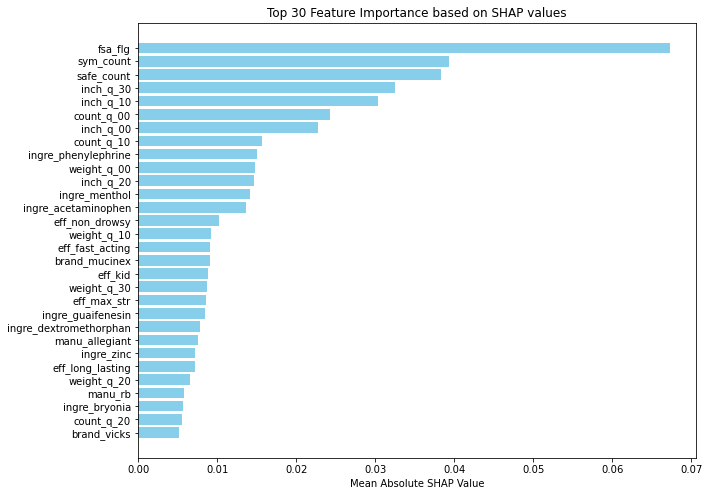

In [24]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Create a SHAP explainer object
explainer = shap.TreeExplainer(rf_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_train)

# Calculate absolute mean SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values[1]), axis=0)  # Considering only the positive class

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame

# Get indices of top 30 features sorted by absolute SHAP values
top_indices = np.argsort(mean_abs_shap_values)[::-1][:30]

# Select top 30 feature names and corresponding mean absolute SHAP values
top_feature_names = [feature_names[i] for i in top_indices]
top_mean_abs_shap_values = mean_abs_shap_values[top_indices]

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_feature_names)), top_mean_abs_shap_values, align='center', color='skyblue')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 30 Feature Importance based on SHAP values')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [25]:
## safe count tricky (phen, acetamin, dex)

In [26]:
top_mean_abs_shap_values

array([0.06723903, 0.03940049, 0.03833668, 0.03251326, 0.03034954,
       0.02432674, 0.02279859, 0.0157373 , 0.0150941 , 0.01474666,
       0.01466019, 0.01419067, 0.01370785, 0.01025868, 0.00924783,
       0.00915865, 0.00907214, 0.00885787, 0.00878363, 0.00854915,
       0.00843044, 0.0078912 , 0.00761954, 0.00723391, 0.00719403,
       0.00655496, 0.00575395, 0.00571269, 0.00553868, 0.00520354])

In [27]:
np.quantile(mean_abs_shap_values,0.95)

0.02295140877412893

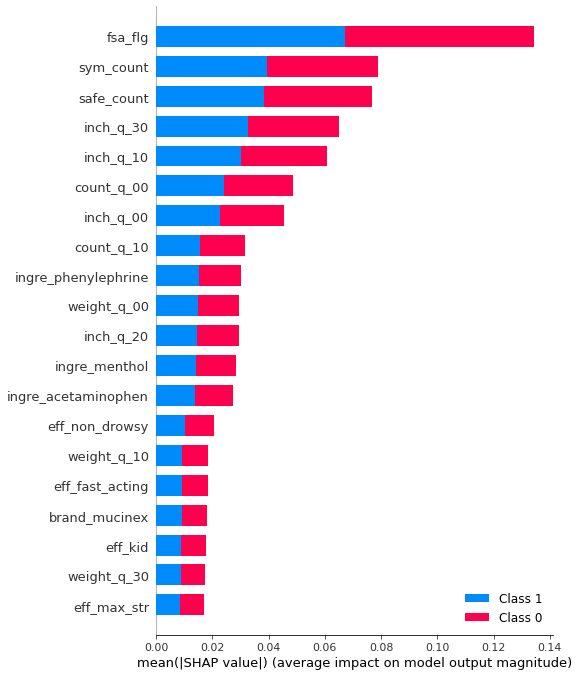

In [28]:
import shap
import matplotlib.pyplot as plt

# Assuming you have already calculated SHAP values and defined the explainer
# Create a summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)

# Show the plot
plt.show()

In [29]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Access feature importances from the Random Forest model
# feature_importances = rf_model.named_steps['classifier'].feature_importances_

# # Create a DataFrame to store feature importances
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# # Sort the DataFrame by Importance in descending order
# feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# # Output the top 30 features
# top_30_features = feature_importance_df.head(25)
# print(top_30_features)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(top_30_features['Feature'], top_30_features['Importance'])
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Top 30 Feature Importance from Random Forest Model')
# plt.show()

In [30]:
## logistic regression feat importance

In [31]:
import pandas as pd

# Extract coefficient estimates
coefficients = lr_model.named_steps['classifier'].coef_[0]

# Calculate p-values (not directly available in scikit-learn)
# You would typically use statsmodels for p-values with logistic regression

# Create a DataFrame to store coefficients and p-values
variable_info = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Calculate absolute coefficients
variable_info['Absolute Coefficient'] = abs(variable_info['Coefficient'])

# Sort variables based on absolute coefficient values
variable_info.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

# You should determine statistical significance based on your chosen method
# Since we don't have p-values directly, you might need to use other statistical tools
# For demonstration purposes, I'm assuming all coefficients are statistically significant
variable_info['Significance'] = True

# Print the ranked variables and their statistical significance
#print(variable_info[:20])

In [32]:
import pandas as pd

# Assuming you have a DataFrame named 'top_feature_names' containing the names of the top features
# and another DataFrame named 'variable_info' containing information about all features

# Filter variable_info to include only rows where the Feature is in top_feature_names
filtered_variable_info = variable_info[variable_info['Feature'].isin(top_feature_names)]

# Order filtered_variable_info by the top_feature_names list
ordered_variable_info = filtered_variable_info.set_index('Feature').loc[top_feature_names].reset_index()
ordered_variable_info

,Feature,Coefficient,Absolute Coefficient,Significance
0,fsa_flg,0.989266,0.989266,True
1,sym_count,0.078064,0.078064,True
2,safe_count,0.050957,0.050957,True
3,inch_q_30,-0.944499,0.944499,True
4,inch_q_10,0.963720,0.963720,True
5,count_q_00,0.499849,0.499849,True
6,inch_q_00,0.965564,0.965564,True
7,count_q_10,-0.996590,0.996590,True
8,ingre_phenylephrine,0.372500,0.372500,True
9,weight_q_00,0.453672,0.453672,True


In [34]:
data[data.ingre_dextromethorphan==1].price.mean(), data[data.ingre_dextromethorphan==0].price.mean()

(14.679312977099245, 18.411499999999954)

In [35]:
data[data.ingre_dextromethorphan==1].rating.mean(), data[data.ingre_dextromethorphan==0].rating.mean()

(4.699236641221376, 4.561875000000002)

In [37]:
data[data.ingre_dextromethorphan==1].y_class.mean(), data[data.ingre_dextromethorphan==0].y_class.mean()

(0.5725190839694656, 0.46875)

In [38]:
data[data.ingre_phenylephrine==1].y_class.mean(), data[data.ingre_phenylephrine==0].y_class.mean()

(0.6320754716981132, 0.4579710144927536)

In [39]:
data[data.ingre_acetaminophen==1].y_class.mean(), data[data.ingre_acetaminophen==0].y_class.mean()

(0.6339285714285714, 0.45427728613569324)